In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jan 30 17:26:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import itertools
from time import time
import os
import numpy as np
import random

from matplotlib import pyplot as plt

In [5]:
RESCALE_SIZE = 512
BATCH_SIZE = 2
EPOCHS = 200
EPOCH_DECAY = 100

In [6]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [7]:
class Generator(nn.Module):
    def __init__(self, init_nc=32):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_nc, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc, out_channels=init_nc, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc),
            nn.ReLU()
            )
        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc, out_channels=init_nc, kernel_size=3, padding=(1, 1), stride=2),
            nn.InstanceNorm2d(init_nc),
            nn.ReLU()
            )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc, out_channels=init_nc*2, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc*2, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*2),
            nn.ReLU()
            )
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc*2, kernel_size=3, padding=(1, 1), stride=2),
            nn.InstanceNorm2d(init_nc*2),
            nn.ReLU()
            )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc*4, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*4, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*4),
            nn.ReLU()
            )
        self.pool2 =  nn.Sequential(
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*4, kernel_size=3, padding=(1, 1), stride=2),
            nn.InstanceNorm2d(init_nc*4),
            nn.ReLU()
            )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*8, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*8, out_channels=init_nc*8, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*8),
            nn.ReLU()
            )
        self.pool3 =  nn.Sequential(
            nn.Conv2d(in_channels=init_nc*8, out_channels=init_nc*8, kernel_size=3, padding=(1, 1), stride=2),
            nn.InstanceNorm2d(init_nc*8),
            nn.ReLU()
            )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*8, out_channels=init_nc*16, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*16, out_channels=init_nc*16, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*16),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=init_nc*16, out_channels=init_nc*8, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*16, out_channels=init_nc*8, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*8, out_channels=init_nc*8, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*8),
            nn.ReLU()
            )
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=init_nc*8, out_channels=init_nc*4, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*8, out_channels=init_nc*4, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*4, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*4),
            nn.ReLU()
            )
        
        self.upsample2 = nn.ConvTranspose2d(in_channels=init_nc*4, out_channels=init_nc*2, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*2, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc*2, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc*2),
            nn.ReLU()
            )
        
        self.upsample3 = nn.ConvTranspose2d(in_channels=init_nc*2, out_channels=init_nc, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_nc, out_channels=init_nc, kernel_size=3, padding=(1, 1)),
            nn.InstanceNorm2d(init_nc),
            nn.ReLU()
            )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(in_channels=init_nc, out_channels=3, kernel_size=1),
            nn.Tanh()
            )
    
    # Начальная инициализация весов
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([e3 , self.upsample0(b)], 1))
        d1 = self.dec_conv1(torch.cat([e2 , self.upsample1(d0)], 1))
        d2 = self.dec_conv2(torch.cat([e1 , self.upsample2(d1)], 1))
        d3 = self.dec_conv3(torch.cat([e0 , self.upsample3(d2)], 1))
        final = self.final_conv(d3)
        return final

In [8]:
class Discriminator(nn.Module):
    def __init__(self, init_nc=32):
        super().__init__()
        self.dis_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_nc, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
            )
        self.dis_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc, out_channels=init_nc*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(init_nc*2),
            nn.LeakyReLU(0.2, inplace=True)
            )
        self.dis_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*2, out_channels=init_nc*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(init_nc*4),
            nn.LeakyReLU(0.2, inplace=True)
            )
        self.dis_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=init_nc*4, out_channels=init_nc*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(init_nc*8),
            nn.LeakyReLU(0.2, inplace=True)
            )
        self.out = nn.Conv2d(in_channels=init_nc*8, out_channels=1, kernel_size=4, padding=1)

    # Начальная инициализация весов        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        d0 = self.dis_conv0(x)
        d1 = self.dis_conv1(d0)
        d2 = self.dis_conv2(d1)
        d3 = self.dis_conv3(d2)
        out = self.out(d3)

        return F.avg_pool2d(out, out.size()[2:]).view(out.size()[0], -1)
        

In [9]:
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, dataset_path, mode):
        super().__init__()
        if mode == 'train':
          self.A_root_path = dataset_path + '/trainA'
          self.B_root_path = dataset_path + '/trainB'
        else:
          self.A_root_path = dataset_path + '/testA'
          self.B_root_path = dataset_path + '/testB'
        self.A_files = os.listdir(self.A_root_path)
        self.B_files = os.listdir(self.B_root_path)
        self.len_ = len(self.A_files)
        self.mode = mode
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # Если датасет тренировачный используем аугментацию
        if self.mode == 'train':
            transform = transforms.Compose([ 
                transforms.ToPILImage(),
                transforms.Resize(int(RESCALE_SIZE*1.12), Image.BICUBIC), 
                transforms.RandomCrop(RESCALE_SIZE), 
                transforms.ToTensor(),
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
            ])
        A = self.load_sample(self.A_root_path + '/' + self.A_files[index])
        B = self.load_sample(self.B_root_path + '/' + self.B_files[random.randint(0, len(self.B_files) - 1)])
        A = self._prepare_sample(A)
        B = self._prepare_sample(B)
        A = transform(A)
        B = transform(B)

        return A, B

        
    def _prepare_sample(self, image):
        image = np.array(image)
        # если попалось чб изображение приведем его в формат RGB
        if image.ndim < 3:
          image = np.repeat(image[ :, :, np.newaxis], 3, axis=2)
        return image

In [10]:
def tensor2image(tensor):
    image = 127.5*(tensor.cpu().detach().numpy() + 1.0)
    return image.astype(np.uint8)

In [11]:
def init_models(gen_init_nc = 32, dec_init_nc=64, checkpoint=None, mode='train'):
  A2B_gen = Generator(gen_init_nc).to(DEVICE)
  B2A_gen = Generator(gen_init_nc).to(DEVICE)
  D_A = Discriminator(dec_init_nc).to(DEVICE)
  D_B = Discriminator(dec_init_nc).to(DEVICE)
  if checkpoint is not None:
    A2B_gen.load_state_dict(checkpoint['A2B_gen_state_dict'])
    B2A_gen.load_state_dict(checkpoint['B2A_gen_state_dict'])
    D_A.load_state_dict(checkpoint['dis_A_state_dict'])
    D_B.load_state_dict(checkpoint['dis_B_state_dict'])

  else:
    A2B_gen.weight_init(mean=0.0, std=0.02)
    B2A_gen.weight_init(mean=0.0, std=0.02)
    D_A.weight_init(mean=0.0, std=0.02)
    D_B.weight_init(mean=0.0, std=0.02)

  if mode == 'train':
    A2B_gen.train()
    B2A_gen.train()
    D_A.train()
    D_B.train()
  else:
    A2B_gen.eval()
    B2A_gen.eval()
    D_A.eval()
    D_B.eval()

  
  return A2B_gen, B2A_gen, D_A, D_B

In [12]:
def plot_img(imgs, titles=None):
  plt.figure(figsize=(16,12))
  for k, img in enumerate(imgs):
      plt.subplot(2, 2, k+1)
      plt.imshow(np.rollaxis(tensor2image(img), 0, 3))
      if titles is not None:
        plt.title(titles[k])
      plt.axis('off')

In [13]:
def train(epochs, train_loader, model_save_path, from_checkpoints=None,
          dis_lr=0.0002, gen_lr=0.0002, epoch_decay=100, 
          gen_init_nc=32, dec_init_nc=64):
  
  checkpoint = torch.load(from_checkpoints) if from_checkpoints is not None else None

  # Инициализируем модели
  A2B_gen, B2A_gen, D_A, D_B = init_models(gen_init_nc, dec_init_nc, checkpoint)

  # Оптимизаторы
  gen_opt = torch.optim.Adam(itertools.chain(A2B_gen.parameters(), B2A_gen.parameters()),
                           lr=gen_lr, betas=(0.5, 0.999))
  D_A_opt = torch.optim.Adam(D_A.parameters(), lr=dis_lr, betas=(0.5, 0.999))
  D_B_opt = torch.optim.Adam(D_B.parameters(), lr=dis_lr, betas=(0.5, 0.999))

  epoch=0
  total_dis_A_loss = []
  total_dis_B_loss = []
  total_gen_loss = []
  

  # Если обучение продолжается с контрольной точки
  # загрузим все предыдущие состояния
  if checkpoint is not None:
    gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
    D_A_opt.load_state_dict(checkpoint['D_A_opt_state_dict'])
    D_B_opt.load_state_dict(checkpoint['D_B_opt_state_dict'])
    total_dis_A_loss = checkpoint['total_dis_A_loss']
    total_dis_B_loss = checkpoint['total_dis_B_loss']
    total_gen_loss = checkpoint['total_gen_loss']
    epoch = checkpoint['epoch']
    
  # Определим функции ошибки для каждого критерия
  plausibility_loss = torch.nn.MSELoss()
  cycle_loss = torch.nn.L1Loss()
  identity_loss = torch.nn.L1Loss()
  
  # Метки верных/ошибочных классов для дискриминатора
  valid = torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0).to(DEVICE)
  fake = torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0).to(DEVICE)

  for e in range(epoch, epochs):
    batch_dis_A_loss = []
    batch_dis_B_loss = []
    batch_gen_loss = [] 

    A2B_gen.train()
    B2A_gen.train()

    # После некоторого порога снижаем скорость обучения
    if (e+1) > epoch_decay:
      gen_opt.param_groups[0]['lr'] -= gen_lr / (epochs - epoch_decay)
      D_A_opt.param_groups[0]['lr'] -= dis_lr / (epochs - epoch_decay)
      D_B_opt.param_groups[0]['lr'] -= dis_lr / (epochs - epoch_decay)

    for i, batch in enumerate(train_loader):
      imgs_A = batch[0].to(DEVICE)
      imgs_B = batch[1].to(DEVICE)

      '''
      Discriminator loss
      Обучим каждый дискриминатор 
      сначала на реальных изображениях
      потом на искуственных
      ''' 
      
      fake_A = B2A_gen(imgs_B)
      fake_B = A2B_gen(imgs_A)
      # D_A Loss
      D_A_opt.zero_grad()
      pred_D_A_real = D_A(imgs_A)
      loss_D_A_real = plausibility_loss(pred_D_A_real, valid)

      pred_D_A_fake = D_A(fake_A.detach())
      loss_D_A_fake = plausibility_loss(pred_D_A_fake, fake)

      loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)

      loss_D_A.backward()
      D_A_opt.step() 

      batch_dis_A_loss.append(loss_D_A.cpu().detach().numpy())

      # D_B Loss
      D_B_opt.zero_grad()
      pred_D_B_real = D_B(imgs_B)
      loss_D_B_real = plausibility_loss(pred_D_B_real, valid)

      pred_D_B_fake = D_B(fake_B.detach())
      loss_D_B_fake = plausibility_loss(pred_D_B_fake, fake)

      loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)

      loss_D_B.backward()
      D_B_opt.step()
      batch_dis_B_loss.append(loss_D_B.cpu().detach().numpy())
    
      '''
      Gen Loss
      Для каждого генератора найдем ошибку
      по каждому из критериев.
      Ошибки каждого критерия имеют разный вес:
      plausibility_loss = 1
      cycle_loss = 10
      identity_loss = 5
      ''' 
      gen_opt.zero_grad()
      # Identity loss
      
      # A2B Identy
      A_id_pred = B2A_gen(imgs_A)
      A_id_loss = identity_loss(A_id_pred, imgs_A)

      # B2A Identy
      B_id_pred = A2B_gen(imgs_B)
      B_id_loss = identity_loss(B_id_pred, imgs_B)

      # Gen_Dis_B loss
      fake_B = A2B_gen(imgs_A)
      pred_A2B = D_B(fake_B)
      loss_A2B = plausibility_loss(pred_A2B, valid)

      # Gen_Dis_A loss
      fake_A = B2A_gen(imgs_B)
      pred_B2A = D_A(fake_A)
      loss_B2A = plausibility_loss(pred_B2A, valid)

      # cycle loss
      reconstr_A = B2A_gen(fake_B)
      cycle_loss_B2A = cycle_loss(reconstr_A, imgs_A)

      reconstr_B = A2B_gen(fake_A)
      cycle_loss_A2B = cycle_loss(reconstr_B, imgs_B)

      # Total loss с применением весов для каждого критерия
      gen_loss = A_id_loss*5.0 + B_id_loss*5.0 + cycle_loss_B2A*10.0 + cycle_loss_A2B*10.0 + loss_A2B + loss_B2A
      gen_loss.backward()
      gen_opt.step()

      batch_gen_loss.append(gen_loss.cpu().detach().numpy())

    total_dis_A_loss.append(np.mean(batch_dis_A_loss))
    total_dis_B_loss.append(np.mean(batch_dis_B_loss))
    total_gen_loss.append(np.mean(batch_gen_loss))

    # Сохраним промежуточную модель
    torch.save({
              'A2B_gen_state_dict': A2B_gen.state_dict(),
              'B2A_gen_state_dict': B2A_gen.state_dict(),
              'dis_A_state_dict': D_A.state_dict(),
              'dis_B_state_dict': D_B.state_dict(),
              'gen_opt_state_dict': gen_opt.state_dict(),
              'D_A_opt_state_dict': D_A_opt.state_dict(),
              'D_B_opt_state_dict': D_B_opt.state_dict(),
              'epoch': e+1,
              'total_dis_A_loss': total_dis_A_loss,
              'total_dis_B_loss': total_dis_B_loss,
              'total_gen_loss': total_gen_loss
              }, model_save_path)

    # Выведем на экран промежуточные результаты работы
    A2B_gen.eval()
    B2A_gen.eval()
    with torch.no_grad():
      Y_pred_A = A2B_gen(imgs_A)
      Y_pred_B = B2A_gen(imgs_B)

    clear_output(wait=True) 

    img4plot = [imgs_A[0], imgs_B[0], Y_pred_A[0], Y_pred_B[0]]
    titles = ['Real A', 'Real B', 'Fake B', 'Fake A']
    plot_img(img4plot, titles)

    plt.suptitle('%d / %d - gen_loss: %f - dis_A_loss: %f - dis_B_loss: %f' % 
                (e+1, EPOCHS, total_gen_loss[-1], total_dis_A_loss[-1], total_dis_B_loss[-1]))
    plt.show()

  return total_dis_A_loss, total_dis_B_loss, total_gen_loss

In [14]:
# Скачаем датасет с гугл диска
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rlUlRODl5N8EVClBFQQBhc6jAzZQbRik' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rlUlRODl5N8EVClBFQQBhc6jAzZQbRik" -O Expressionism2photo.zip && rm -rf /tmp/cookies.txt


--2021-01-30 17:26:21--  https://docs.google.com/uc?export=download&confirm=uTX2&id=1rlUlRODl5N8EVClBFQQBhc6jAzZQbRik
Resolving docs.google.com (docs.google.com)... 74.125.143.139, 74.125.143.113, 74.125.143.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.143.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4k-docs.googleusercontent.com/docs/securesc/m3hq025a565pvdqt065u9i1hlcm3ru86/e2ebtnk25agp3mng1fg93nt987fho306/1612027575000/11030441499116382128/14619977637925550433Z/1rlUlRODl5N8EVClBFQQBhc6jAzZQbRik?e=download [following]
--2021-01-30 17:26:21--  https://doc-10-4k-docs.googleusercontent.com/docs/securesc/m3hq025a565pvdqt065u9i1hlcm3ru86/e2ebtnk25agp3mng1fg93nt987fho306/1612027575000/11030441499116382128/14619977637925550433Z/1rlUlRODl5N8EVClBFQQBhc6jAzZQbRik?e=download
Resolving doc-10-4k-docs.googleusercontent.com (doc-10-4k-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting

In [15]:
# разархивируем
!unzip -q /content/Expressionism2photo.zip -d Expressionism2photo

In [16]:
train_dataset = ImageDataset('/content/Expressionism2photo', mode='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True, num_workers=8)

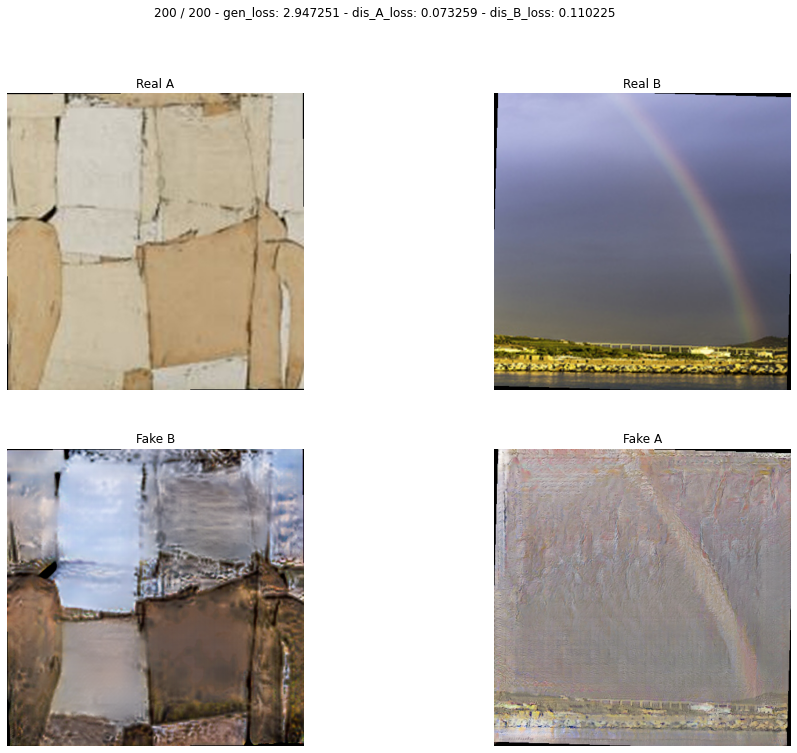

In [17]:
# Обучим
checkpoint_dir = '/content/drive/MyDrive/dls/TelegramBot/checkpoints/Expressionism2photo/checkpoint.tar'
dis_A_loss, dis_B_loss, gen_loss = train(EPOCHS, train_loader, checkpoint_dir,
                                         from_checkpoints=checkpoint_dir)

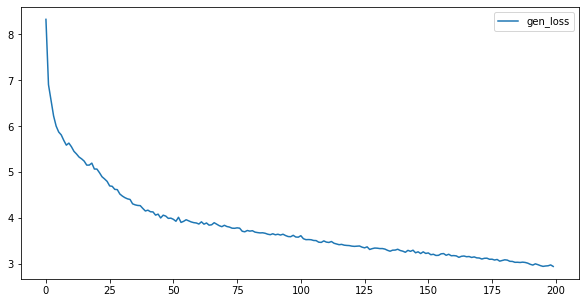

In [18]:
plt.figure(figsize=(10,5))
plt.plot(gen_loss, label='gen_loss')
plt.legend()
plt.show()

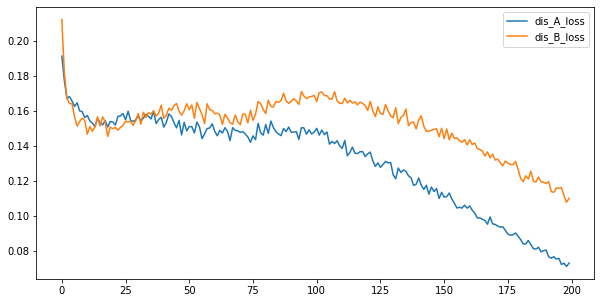

In [19]:
plt.figure(figsize=(10,5))
plt.plot(dis_A_loss, label='dis_A_loss')
plt.plot(dis_B_loss, label='dis_B_loss')
plt.legend()
plt.show()